# Title: Brexit under the lens

<p align="center">
  <img width="460" height="300" src="https://www.dachser.com/en/mediaroom/images/Corporate/Marktinformation/shutterstock_417868516_rdax_65.jpg">
</p>

# Import Libraries

In [ ]:
# Load the data folder in the share drives
# The data folder is in the 'drive/Shareddrives/Ada'
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Downgrade the pandas version so that we can read data in chunksize
#!pip install pandas==1.0.5

In [ ]:
!pip install textblob

In [ ]:
# Import library
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import warnings
import pickle
import shutil
import os
import glob
import wordcloud
import nltk
import re
warnings.filterwarnings('ignore')

import requests 
from bs4 import BeautifulSoup

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
import sys
import spacy
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

#URL parsing
from urllib.parse import parse_qsl, urljoin, urlparse

In [ ]:
import plotly.express as px

In [ ]:
# NLTK Stop words
#from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Data collection

In [ ]:
# The original datafile path, contains all the Quote from 2015-2020
dataset_path='/content/drive/Shareddrives/Ada/Quotebank'

# The path store the first preprocessed Pickles 
pickle_path='/content/drive/Shareddrives/Ada/pickle'

# Specify which cols to drop and which to keep
use_cols=["qids","quoteID","quotation","speaker","date","numOccurrences","probas","urls","phase"]
ignore_cols=[]

# The chunk_size for the pickles
chunk_size = 600000 

In [ ]:
# Only run this block when remove the pickles and make new pickles
shutil.rmtree(pickle_path)
os.mkdir(pickle_path)

In [ ]:
# Check if the data has been processed and saved into pickles already 
# If not, process raw data into pickles
if not os.listdir(pickle_path):
   for name in glob.glob(dataset_path + "/*.bz2"):
     print("pickling "+name)
     pickle_name=name.split('/')[6].split('.')[0]
     reader = pd.read_json(name, chunksize=chunk_size, lines=True, compression='bz2')   
     for i, chunk in enumerate(reader):
       chunk=chunk[use_cols]
       out_file = pickle_path + "/"+ pickle_name + "_{}.pkl".format(i+1)
       with open(out_file, "wb") as f:
           pickle.dump(chunk,f,pickle.HIGHEST_PROTOCOL)
       chunk=""    
   print('Pickles made!,ready to go!')       
else:    
   print("Already processed data into pickles, you can use them right away!")

Already processed data into pickles, you can use them right away!


In [ ]:
# Filter the pickles and extract Brexit related data
# Define the path to store the processed pickle
processed_path='/content/drive/Shareddrives/Ada/processed' 
out_file = processed_path + "/"+"Brexit_related_quote.pkl"

# Specify the orginal pickles we want to process
if not os.path.exists(out_file):
  data_p_files=[]
  for name in glob.glob(pickle_path + "/*.pkl"):
    data_p_files.append(name)

  # Add all the df into here and store it into pickle in the end
  appended_data=[]
  for i in range(len(data_p_files)):
    print("processing"+data_p_files[i])
    df=pd.read_pickle(data_p_files[i])
    # Filter quotations only in phase E
    df=df.loc[df['phase']=='E']
    df=df.loc[df['speaker']!='None']
    # Filter quotations only relevant to Brexit or both UK and EU firtsly
    df=df.loc[df['quotation'].str.contains('Brexit|UK.*EU|EU.*UK|United Kingdom.*European Union|European Union.*United Kingdom|British.*EU|EU.*British',case = False)]
    # Define key words relevant to Brexit to filter related news from the quotations that only relevant to UK and EU 
    searchfor = ['brexit','leave campaign and remain campaign','no deal', 'transition period','leave','withdral','referendum', 'split from']
    # Filter quotations which contained (EU and UK) or (Breix) which also contained those keywords we defined above
    df=df.loc[df['quotation'].str.contains('|'.join(searchfor),case = False)]

    appended_data.append(df)
    # release the df at the end of process
    # To free the memory
    df = ""  
    
    # concat and append results
    appended_data = pd.concat(appended_data)
    appended_data.to_pickle(out_file)
else:    
   print("Already processed data into pickle, you can use them right away!")

Already processed data into pickle, you can use them right away!


In [ ]:
# Merge the original Brexit related quotation dataset with speaker attributes by joining the QIDs
# Define the output pickle path
all_attribute_pickle_path='/content/drive/Shareddrives/Ada/processed/All_attribute.pkl'
if not os.path.exists(all_attribute_pickle_path):
  parquet_path='/content/drive/Shareddrives/Ada/Project datasets/speaker_attributes.parquet'
  label_path='/content/drive/Shareddrives/Ada/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2'
  df=pd.read_pickle('/content/drive/Shareddrives/Ada/processed/Brexit_related_quote.pkl')
  df['qids']=df['qids'].map(lambda x:str(x[0]))
  df.rename(columns={"qids":"id"},inplace=True)
  parquet_cols=['id','label','date_of_birth','nationality','gender','ethnic_group','occupation','party','academic_degree','religion']

  # recursively add the cols and update to our dataframe
  for name in glob.glob(parquet_path + "/*.parquet"):
    par=pd.read_parquet(name)
    par=par[parquet_cols]
    #Check if the merge has been done
    if 'gender' not in df.columns:
      df = pd.merge(df, par,on='id',how='left')
    else:
      df=df.set_index('id')
      df.update(par.set_index('id'))
      df.reset_index(inplace=True)
  
  # Replace NAN with value 0 in order to make the following process become easy
  df = df.fillna('0')
  cols=['nationality','gender','ethnic_group','occupation','party','academic_degree','religion']

  # Always keep the first qid label
  for col in cols:
    df[col]=df[col].map(lambda x: x[0])

  df_label=pd.read_csv(label_path,compression='bz2',index_col='QID')
  # replace the qid with actuall text label
  for col in cols:
    df[col]=df[col].map(lambda x: df_label.loc[x]['Label'] if x in df_label.index else x)
  df.to_pickle(all_attribute_pickle_path)

In [ ]:
# Read the dataset after merging with speaker attributes
df=pd.read_pickle('/content/drive/Shareddrives/Ada/processed/All_attribute.pkl')
df.head(5)

,id,quoteID,quotation,speaker,probas,date,numOccurrences,urls,phase,label,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,religion
0,Q20251661,2020-01-31-011304,Brexit is the victory of the common people aga...,Laura Huhtasaari,"[[Laura Huhtasaari, 0.9325], [None, 0.059], [P...",2020-01-31 03:25:04,1,[http://voanews.com/europe/shrug-and-some-sorr...,E,Laura Huhtasaari,[+1979-03-30T00:00:00Z],Finland,female,0,politician,Finns Party,0,Lutheranism
1,Q694676,2020-02-13-014393,Certainly Brexit was a big issue and people we...,Pat McFadden,"[[Pat McFadden, 0.9371], [None, 0.0535], [Jere...",2020-02-13 06:01:30,1,[http://www.expressandstar.com/news/politics/2...,E,Pat McFadden,[+1965-03-26T00:00:00Z],United Kingdom,male,0,politician,Labour Party,0,0
2,Q1341937,2020-03-08-010480,"I backed leave and voted leave, but I never ca...",Jason McCartney,"[[Jason McCartney, 0.8274], [None, 0.128], [Li...",2020-03-08 05:45:58,1,[http://www.yorkshirepost.co.uk/news/second-ti...,E,Jason McCartney,[+1973-09-03T00:00:00Z],United States of America,male,0,sport cyclist,0,0,0
3,Q6837191,2020-02-14-058019,"legacy, bad faith on pensions, Brexit and poli...",Michelle O'Neill,"[[Michelle O'Neill, 0.8055], [None, 0.1302], [...",2020-02-14 11:48:49,1,[https://www.belfasttelegraph.co.uk/news/north...,E,Michelle O'Neill,[+1977-01-10T00:00:00Z],Northern Ireland,female,0,politician,Sinn Féin,0,0
4,Q1728820,2020-01-27-094916,"we're only at half-time on Brexit, it's not do...",Leo Varadkar,"[[Leo Varadkar, 0.9378], [None, 0.0502], [Bori...",2020-01-27 12:25:00,1,[http://blogs.independent.co.uk/voices/brexit-...,E,Leo Varadkar,[+1979-01-18T00:00:00Z],Ireland,male,0,politician,Fine Gael,0,0


# Preliminary Analysis

## How many quotations related to Brexit

In [ ]:
df.shape[0]

101878

We thus have more thant 101 thousands datapoints containing quotations we judge related to Brexit. We consider it enough to run the analysis.

In [ ]:
# Remove punctuation
df['quotation_processed'] = \
df["quotation"].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
df['quotation_processed'] = \
df['quotation_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
df['quotation_processed'].head()

0    brexit is the victory of the common people aga...
1    certainly brexit was a big issue and people we...
2    i backed leave and voted leave but i never cal...
3    legacy bad faith on pensions brexit and politi...
4    we're only at half-time on brexit it's not don...
Name: quotation_processed, dtype: object

# Sentiment analysis 

## Method 1: using package TextBlob

In [ ]:
from textblob import TextBlob

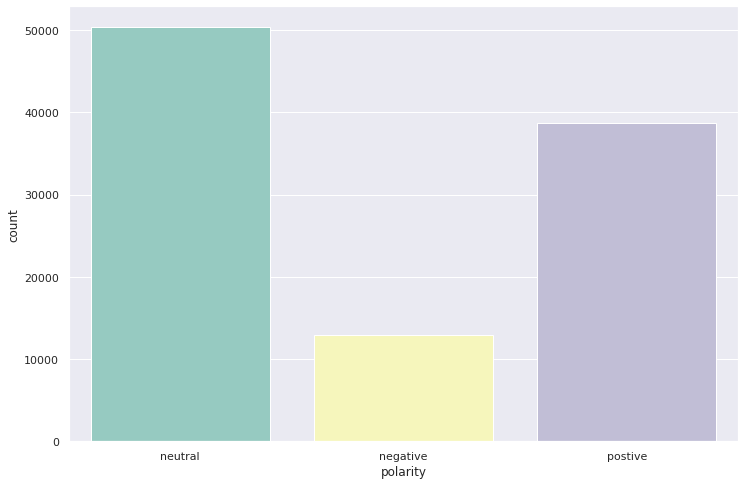

In [ ]:
# perform a naive sentimental analysis
if 'polarity' not in df.columns:
  df.insert(df.shape[1],'polarity','None')

# this function simply return the sentiment classification for the scentence
def polarity_to_text(blob):  
      if (blob.sentiment.polarity > 0.1):
        #'Polarity is positive 😊'
          return 'postive'
      elif(blob.sentiment.polarity <= 0.1 and  blob.sentiment.polarity >= -0.1):
          # 'Polarity is neutral 😐'
          return 'neutral'
      else:
        # 'Polarity is negative 😡' 
          return 'negative'

def get_polarity(blob):
  return blob.sentiment.polarity

if df.iloc[1].polarity=="None":
  for i,data in df.iterrows():
    blob = TextBlob(data.quotation)
    emotion=polarity_to_text(blob)
    polarity= get_polarity(blob)
    df.at[i,'polarity_TextBlob']=polarity
    df.at[i,'polarity']=emotion



plt.figure(figsize=(12,8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="polarity", data=df,palette="Set3")
plt.show()

In [ ]:
df.columns

Index(['id', 'quoteID', 'quotation', 'speaker', 'probas', 'date',
       'numOccurrences', 'urls', 'phase', 'label', 'date_of_birth',
       'nationality', 'gender', 'ethnic_group', 'occupation', 'party',
       'academic_degree', 'religion', 'polarity_TextBlob', 'polarity'],
      dtype='object')

Because we don't really need the result of each method since we will average, we drop it:

In [ ]:
df=df.drop(['polarity'], axis=1)
df.columns

Index(['id', 'quoteID', 'quotation', 'speaker', 'probas', 'date',
       'numOccurrences', 'urls', 'phase', 'label', 'date_of_birth',
       'nationality', 'gender', 'ethnic_group', 'occupation', 'party',
       'academic_degree', 'religion', 'polarity_TextBlob'],
      dtype='object')

In [ ]:
df.to_pickle('/content/drive/Shareddrives/Ada/SentimentAnalysis_temp.pkl')

According to our first sentiment analysis result, most of quotations reflect neutral attitude towards Brexit. It's noticeable that amount of quotations showing positive attitudes is much higher than showing negative attitudes. But, those results may not accurate. We will update the sentiment analysis in milestone 3!

## Method 2: using package Sentiment Intensity Analyser

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
import operator
nltk.download('vader_lexicon')

In [ ]:
#defining our model:
sia = SentimentIntensityAnalyzer()

# score of sentiment analysis
df["polarity_SentimentIntensityAnalyze"] = df['quotation'].apply(lambda x: sia.polarity_scores(x)["compound"])

In [ ]:
# Define the emotion according to the polarity
if 'emotion_SentimentIntensityAnalyze' not in df.columns:
  df.insert(df.shape[1],'emotion_SentimentIntensityAnalyze','None')

def polarity_to_text2(row):  
      if (row> 0.1):
        #'Polarity is positive 😊'
          return 'postive'
      elif(row <= 0.1 and  row >= -0.1):
          # 'Polarity is neutral 😐'
          return 'neutral'
      else:
        # 'Polarity is negative 😡' 
          return 'negative'



for i in range(len(df)):
  df.at[i,'emotion_SentimentIntensityAnalyze']=polarity_to_text2(df['polarity_SentimentIntensityAnalyze'][i])


In [ ]:
df.head()

,id,quoteID,quotation,speaker,probas,date,numOccurrences,urls,phase,label,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,religion,polarity_TextBlob,polarity_SentimentIntensityAnalyze,emotion_SentimentIntensityAnalyze
0,Q20251661,2020-01-31-011304,Brexit is the victory of the common people aga...,Laura Huhtasaari,"[[Laura Huhtasaari, 0.9325], [None, 0.059], [P...",2020-01-31 03:25:04,1,[http://voanews.com/europe/shrug-and-some-sorr...,E,Laura Huhtasaari,[+1979-03-30T00:00:00Z],Finland,female,0,politician,Finns Party,0,Lutheranism,-0.022619,0.5719,postive
1,Q694676,2020-02-13-014393,Certainly Brexit was a big issue and people we...,Pat McFadden,"[[Pat McFadden, 0.9371], [None, 0.0535], [Jere...",2020-02-13 06:01:30,1,[http://www.expressandstar.com/news/politics/2...,E,Pat McFadden,[+1965-03-26T00:00:00Z],United Kingdom,male,0,politician,Labour Party,0,0,-0.161905,-0.2500,negative
2,Q1341937,2020-03-08-010480,"I backed leave and voted leave, but I never ca...",Jason McCartney,"[[Jason McCartney, 0.8274], [None, 0.128], [Li...",2020-03-08 05:45:58,1,[http://www.yorkshirepost.co.uk/news/second-ti...,E,Jason McCartney,[+1973-09-03T00:00:00Z],United States of America,male,0,sport cyclist,0,0,0,0.000000,-0.4243,negative
3,Q6837191,2020-02-14-058019,"legacy, bad faith on pensions, Brexit and poli...",Michelle O'Neill,"[[Michelle O'Neill, 0.8055], [None, 0.1302], [...",2020-02-14 11:48:49,1,[https://www.belfasttelegraph.co.uk/news/north...,E,Michelle O'Neill,[+1977-01-10T00:00:00Z],Northern Ireland,female,0,politician,Sinn Féin,0,0,-0.233333,-0.0516,neutral
4,Q1728820,2020-01-27-094916,"we're only at half-time on Brexit, it's not do...",Leo Varadkar,"[[Leo Varadkar, 0.9378], [None, 0.0502], [Bori...",2020-01-27 12:25:00,1,[http://blogs.independent.co.uk/voices/brexit-...,E,Leo Varadkar,[+1979-01-18T00:00:00Z],Ireland,male,0,politician,Fine Gael,0,0,0.000000,0.0000,neutral


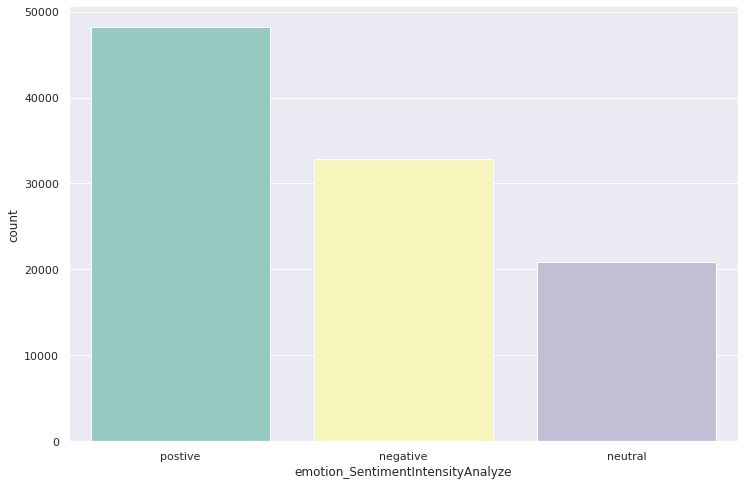

In [ ]:
# View the distribution of emotions
plt.figure(figsize=(12,8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion_SentimentIntensityAnalyze", data=df,palette="Set3")
plt.show()

In [ ]:
# again dropping the result:
df=df.drop(['emotion_SentimentIntensityAnalyze'], axis=1)
df.columns

Index(['id', 'quoteID', 'quotation', 'speaker', 'probas', 'date',
       'numOccurrences', 'urls', 'phase', 'label', 'date_of_birth',
       'nationality', 'gender', 'ethnic_group', 'occupation', 'party',
       'academic_degree', 'religion', 'polarity_TextBlob',
       'polarity_SentimentIntensityAnalyze'],
      dtype='object')

In [ ]:
df.to_pickle('/content/drive/Shareddrives/Ada/SentimentAnalysis_temp.pkl')

Method 3: Using the Flair Package:

In [ ]:
!pip install flair

     |████████████████████████████████| 322 kB 5.2 MB/s 
     |████████████████████████████████| 19.7 MB 1.3 MB/s 
     |████████████████████████████████| 64 kB 2.8 MB/s 
     |████████████████████████████████| 3.3 MB 35.6 MB/s 
     |████████████████████████████████| 61 kB 501 kB/s 
     |████████████████████████████████| 788 kB 51.6 MB/s 
     |████████████████████████████████| 981 kB 28.0 MB/s 
     |████████████████████████████████| 48 kB 5.3 MB/s 
     |████████████████████████████████| 1.2 MB 44.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 62 kB 827 kB/s 
     |████████████████████████████████| 895 kB 40.8 MB/s 
     |████████████████████████████████| 3.3 MB 36.2 MB/s 
     |████████████████████████████████| 596 kB 46.6 MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9704 sha256=1b5e5cfa39ecd72e14dd6f9fc0906d2bab987336a1655b

In [ ]:
from flair.models import TextClassifier
from flair.data import Sentence
sia = TextClassifier.load('en-sentiment')

2021-12-10 14:10:37,775 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmp238rnh3w


100%|██████████| 265512723/265512723 [00:12<00:00, 22026411.18B/s]

2021-12-10 14:10:50,209 copying /tmp/tmp238rnh3w to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2021-12-10 14:10:50,741 removing temp file /tmp/tmp238rnh3w
2021-12-10 14:10:50,783 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
def flair_prediction(x):
    sentence = Sentence(x)
    sia.predict(sentence)
    score = sentence.labels[0]
    if "POSITIVE" in str(score):
        return "positive"
    elif "NEGATIVE" in str(score):
        return "negative"
    else:
        return "neutral"

def flair_score(x):
    sentence = Sentence(x)
    sia.predict(sentence)
    score = sentence.labels[0].score
    return score


In [ ]:
df["emotion_Flair"] = df["quotation"].apply(flair_prediction)

In [ ]:
df["polarity_Flair"] = df["quotation"].apply(flair_score)

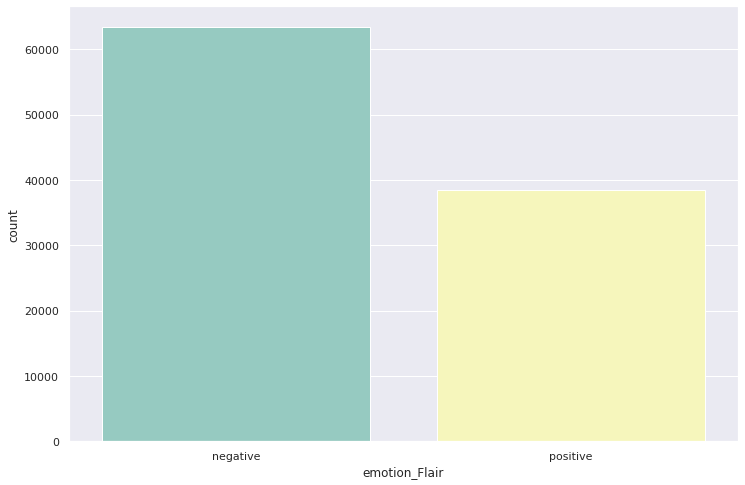

In [ ]:
plt.figure(figsize=(12,8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion_Flair", data=df,palette="Set3")
plt.show()

Notice how here no neutral emotion was detected.

In [ ]:
# again dropping the result:
df=df.drop(['emotion_Flair'], axis=1)
df.columns

Index(['id', 'quoteID', 'quotation', 'speaker', 'probas', 'date',
       'numOccurrences', 'urls', 'phase', 'label', 'date_of_birth',
       'nationality', 'gender', 'ethnic_group', 'occupation', 'party',
       'academic_degree', 'religion', 'polarity_TextBlob',
       'polarity_SentimentIntensityAnalyze', 'polarity_Flair'],
      dtype='object')

In [ ]:
df.to_pickle('/content/drive/Shareddrives/Ada/SentimentAnalysis_temp.pkl')

Averaging the results:

In [ ]:
df['polarity']=df[['polarity_Flair','polarity_TextBlob',
       'polarity_SentimentIntensityAnalyze']].mean(axis=1)

In [ ]:
df.head()

,id,quoteID,quotation,speaker,probas,date,numOccurrences,urls,phase,label,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,religion,polarity_TextBlob,polarity_SentimentIntensityAnalyze,polarity_Flair,polarity
0,Q20251661,2020-01-31-011304,Brexit is the victory of the common people aga...,Laura Huhtasaari,"[[Laura Huhtasaari, 0.9325], [None, 0.059], [P...",2020-01-31 03:25:04,1,[http://voanews.com/europe/shrug-and-some-sorr...,E,Laura Huhtasaari,[+1979-03-30T00:00:00Z],Finland,female,0,politician,Finns Party,0,Lutheranism,-0.022619,0.5719,0.663805,0.404362
1,Q694676,2020-02-13-014393,Certainly Brexit was a big issue and people we...,Pat McFadden,"[[Pat McFadden, 0.9371], [None, 0.0535], [Jere...",2020-02-13 06:01:30,1,[http://www.expressandstar.com/news/politics/2...,E,Pat McFadden,[+1965-03-26T00:00:00Z],United Kingdom,male,0,politician,Labour Party,0,0,-0.161905,-0.2500,0.997470,0.195188
2,Q1341937,2020-03-08-010480,"I backed leave and voted leave, but I never ca...",Jason McCartney,"[[Jason McCartney, 0.8274], [None, 0.128], [Li...",2020-03-08 05:45:58,1,[http://www.yorkshirepost.co.uk/news/second-ti...,E,Jason McCartney,[+1973-09-03T00:00:00Z],United States of America,male,0,sport cyclist,0,0,0,0.000000,-0.4243,0.595703,0.057134
3,Q6837191,2020-02-14-058019,"legacy, bad faith on pensions, Brexit and poli...",Michelle O'Neill,"[[Michelle O'Neill, 0.8055], [None, 0.1302], [...",2020-02-14 11:48:49,1,[https://www.belfasttelegraph.co.uk/news/north...,E,Michelle O'Neill,[+1977-01-10T00:00:00Z],Northern Ireland,female,0,politician,Sinn Féin,0,0,-0.233333,-0.0516,0.951277,0.222115
4,Q1728820,2020-01-27-094916,"we're only at half-time on Brexit, it's not do...",Leo Varadkar,"[[Leo Varadkar, 0.9378], [None, 0.0502], [Bori...",2020-01-27 12:25:00,1,[http://blogs.independent.co.uk/voices/brexit-...,E,Leo Varadkar,[+1979-01-18T00:00:00Z],Ireland,male,0,politician,Fine Gael,0,0,0.000000,0.0000,0.946059,0.315353


In [ ]:
df.to_pickle('/content/drive/Shareddrives/Ada/SentimentAnalysis_temp.pkl')

Assigning the emotion to the averaged score:

In [ ]:
for i in range(len(df)):
  df.at[i,'emotion']=polarity_to_text2(df['polarity'][i])

In [ ]:
df.head()

,id,quoteID,quotation,speaker,probas,date,numOccurrences,urls,phase,label,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,religion,polarity_TextBlob,polarity_SentimentIntensityAnalyze,polarity_Flair,polarity,emotion
0,Q20251661,2020-01-31-011304,Brexit is the victory of the common people aga...,Laura Huhtasaari,"[[Laura Huhtasaari, 0.9325], [None, 0.059], [P...",2020-01-31 03:25:04,1,[http://voanews.com/europe/shrug-and-some-sorr...,E,Laura Huhtasaari,[+1979-03-30T00:00:00Z],Finland,female,0,politician,Finns Party,0,Lutheranism,-0.022619,0.5719,0.663805,0.404362,postive
1,Q694676,2020-02-13-014393,Certainly Brexit was a big issue and people we...,Pat McFadden,"[[Pat McFadden, 0.9371], [None, 0.0535], [Jere...",2020-02-13 06:01:30,1,[http://www.expressandstar.com/news/politics/2...,E,Pat McFadden,[+1965-03-26T00:00:00Z],United Kingdom,male,0,politician,Labour Party,0,0,-0.161905,-0.2500,0.997470,0.195188,postive
2,Q1341937,2020-03-08-010480,"I backed leave and voted leave, but I never ca...",Jason McCartney,"[[Jason McCartney, 0.8274], [None, 0.128], [Li...",2020-03-08 05:45:58,1,[http://www.yorkshirepost.co.uk/news/second-ti...,E,Jason McCartney,[+1973-09-03T00:00:00Z],United States of America,male,0,sport cyclist,0,0,0,0.000000,-0.4243,0.595703,0.057134,neutral
3,Q6837191,2020-02-14-058019,"legacy, bad faith on pensions, Brexit and poli...",Michelle O'Neill,"[[Michelle O'Neill, 0.8055], [None, 0.1302], [...",2020-02-14 11:48:49,1,[https://www.belfasttelegraph.co.uk/news/north...,E,Michelle O'Neill,[+1977-01-10T00:00:00Z],Northern Ireland,female,0,politician,Sinn Féin,0,0,-0.233333,-0.0516,0.951277,0.222115,postive
4,Q1728820,2020-01-27-094916,"we're only at half-time on Brexit, it's not do...",Leo Varadkar,"[[Leo Varadkar, 0.9378], [None, 0.0502], [Bori...",2020-01-27 12:25:00,1,[http://blogs.independent.co.uk/voices/brexit-...,E,Leo Varadkar,[+1979-01-18T00:00:00Z],Ireland,male,0,politician,Fine Gael,0,0,0.000000,0.0000,0.946059,0.315353,postive


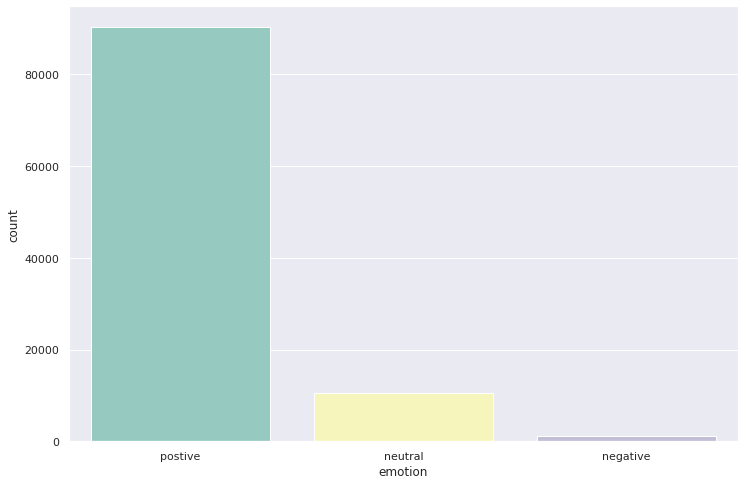

In [ ]:
plt.figure(figsize=(12,8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=df,palette="Set3")
plt.show()

Putting everything in one pickel:

In [ ]:
df.to_pickle('/content/drive/Shareddrives/Ada/SentimentAnalysis.pkl')

In [ ]:
# reading our pickle and verifying it contains all the wanted columns
df=pd.read_pickle('/content/drive/Shareddrives/Ada/SentimentAnalysis.pkl')
df.columns

Index(['id', 'quoteID', 'quotation', 'speaker', 'probas', 'date',
       'numOccurrences', 'urls', 'phase', 'label', 'date_of_birth',
       'nationality', 'gender', 'ethnic_group', 'occupation', 'party',
       'academic_degree', 'religion', 'polarity_TextBlob',
       'polarity_SentimentIntensityAnalyze', 'polarity_Flair', 'polarity',
       'emotion'],
      dtype='object')

In [ ]:
# Correction of typo
df['emotion']=df['emotion'].replace("postive","positive")

In [ ]:
df.head()

,id,quoteID,quotation,speaker,probas,date,numOccurrences,urls,phase,label,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,religion,polarity_TextBlob,polarity_SentimentIntensityAnalyze,polarity_Flair,polarity,emotion
0,Q20251661,2020-01-31-011304,Brexit is the victory of the common people aga...,Laura Huhtasaari,"[[Laura Huhtasaari, 0.9325], [None, 0.059], [P...",2020-01-31 03:25:04,1,[http://voanews.com/europe/shrug-and-some-sorr...,E,Laura Huhtasaari,[+1979-03-30T00:00:00Z],Finland,female,0,politician,Finns Party,0,Lutheranism,-0.022619,0.5719,0.663805,0.404362,positive
1,Q694676,2020-02-13-014393,Certainly Brexit was a big issue and people we...,Pat McFadden,"[[Pat McFadden, 0.9371], [None, 0.0535], [Jere...",2020-02-13 06:01:30,1,[http://www.expressandstar.com/news/politics/2...,E,Pat McFadden,[+1965-03-26T00:00:00Z],United Kingdom,male,0,politician,Labour Party,0,0,-0.161905,-0.2500,0.997470,0.195188,positive
2,Q1341937,2020-03-08-010480,"I backed leave and voted leave, but I never ca...",Jason McCartney,"[[Jason McCartney, 0.8274], [None, 0.128], [Li...",2020-03-08 05:45:58,1,[http://www.yorkshirepost.co.uk/news/second-ti...,E,Jason McCartney,[+1973-09-03T00:00:00Z],United States of America,male,0,sport cyclist,0,0,0,0.000000,-0.4243,0.595703,0.057134,neutral
3,Q6837191,2020-02-14-058019,"legacy, bad faith on pensions, Brexit and poli...",Michelle O'Neill,"[[Michelle O'Neill, 0.8055], [None, 0.1302], [...",2020-02-14 11:48:49,1,[https://www.belfasttelegraph.co.uk/news/north...,E,Michelle O'Neill,[+1977-01-10T00:00:00Z],Northern Ireland,female,0,politician,Sinn Féin,0,0,-0.233333,-0.0516,0.951277,0.222115,positive
4,Q1728820,2020-01-27-094916,"we're only at half-time on Brexit, it's not do...",Leo Varadkar,"[[Leo Varadkar, 0.9378], [None, 0.0502], [Bori...",2020-01-27 12:25:00,1,[http://blogs.independent.co.uk/voices/brexit-...,E,Leo Varadkar,[+1979-01-18T00:00:00Z],Ireland,male,0,politician,Fine Gael,0,0,0.000000,0.0000,0.946059,0.315353,positive


In [ ]:
# adding the features date and year from the date and hour to study the change in 
df['day']=df['date'].dt.date
df['year']=df['date'].dt.year

## Add domains and countries of domains

In [ ]:
#Function tp change urls to domains
def function(row):
  list_domains = []
  for url in row:
    list_domains.append(urlparse(url).netloc)
  return list_domains

df['domains'] = df['urls'].apply(function)
#Building TLD column
df['TLD']=df['domains'].apply(lambda x: x[0].split('.')[-1])
df.head()

,id,quoteID,quotation,speaker,probas,date,numOccurrences,urls,phase,label,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,religion,polarity_TextBlob,polarity_SentimentIntensityAnalyze,polarity_Flair,polarity,emotion,day,year,domains,TLD
0,Q20251661,2020-01-31-011304,Brexit is the victory of the common people aga...,Laura Huhtasaari,"[[Laura Huhtasaari, 0.9325], [None, 0.059], [P...",2020-01-31 03:25:04,1,[http://voanews.com/europe/shrug-and-some-sorr...,E,Laura Huhtasaari,[+1979-03-30T00:00:00Z],Finland,female,0,politician,Finns Party,0,Lutheranism,-0.022619,0.5719,0.663805,0.404362,positive,2020-01-31,2020,[voanews.com],com
1,Q694676,2020-02-13-014393,Certainly Brexit was a big issue and people we...,Pat McFadden,"[[Pat McFadden, 0.9371], [None, 0.0535], [Jere...",2020-02-13 06:01:30,1,[http://www.expressandstar.com/news/politics/2...,E,Pat McFadden,[+1965-03-26T00:00:00Z],United Kingdom,male,0,politician,Labour Party,0,0,-0.161905,-0.2500,0.997470,0.195188,positive,2020-02-13,2020,[www.expressandstar.com],com
2,Q1341937,2020-03-08-010480,"I backed leave and voted leave, but I never ca...",Jason McCartney,"[[Jason McCartney, 0.8274], [None, 0.128], [Li...",2020-03-08 05:45:58,1,[http://www.yorkshirepost.co.uk/news/second-ti...,E,Jason McCartney,[+1973-09-03T00:00:00Z],United States of America,male,0,sport cyclist,0,0,0,0.000000,-0.4243,0.595703,0.057134,neutral,2020-03-08,2020,[www.yorkshirepost.co.uk],uk
3,Q6837191,2020-02-14-058019,"legacy, bad faith on pensions, Brexit and poli...",Michelle O'Neill,"[[Michelle O'Neill, 0.8055], [None, 0.1302], [...",2020-02-14 11:48:49,1,[https://www.belfasttelegraph.co.uk/news/north...,E,Michelle O'Neill,[+1977-01-10T00:00:00Z],Northern Ireland,female,0,politician,Sinn Féin,0,0,-0.233333,-0.0516,0.951277,0.222115,positive,2020-02-14,2020,[www.belfasttelegraph.co.uk],uk
4,Q1728820,2020-01-27-094916,"we're only at half-time on Brexit, it's not do...",Leo Varadkar,"[[Leo Varadkar, 0.9378], [None, 0.0502], [Bori...",2020-01-27 12:25:00,1,[http://blogs.independent.co.uk/voices/brexit-...,E,Leo Varadkar,[+1979-01-18T00:00:00Z],Ireland,male,0,politician,Fine Gael,0,0,0.000000,0.0000,0.946059,0.315353,positive,2020-01-27,2020,[blogs.independent.co.uk],uk


In [ ]:
# Using beautiful soup to get the country of the domain
url = 'https://icannwiki.org/Country_code_top-level_domain'
r = requests.get(url)
soup = BeautifulSoup(r.text, 'html.parser')
ccTLD_table = soup.find('table')
table = []
for ccTLD in ccTLD_table.find_all('tbody'):
    rows = ccTLD.find_all('tr')
    for row in rows:
        columns = row.find_all('td')
        table.append([columns[0].text, columns[1].text])

In [ ]:
country_domain = pd.DataFrame(table)
country_domain.columns = ['TLD', 'domain_country']
country_domain.drop(0,axis=0,inplace=True)
country_domain
country_domain['TLD']=country_domain['TLD'].apply(lambda x: x.split('.')[-1])
country_domain.head()

,TLD,domain_country
1,ac,Ascension Island
2,ad,Andorra
3,ae,United Arab Emirates
4,af,Afghanistan
5,ag,Antigua and Barbuda


In [ ]:
df = pd.merge(left=df, right=country_domain, how="left", on="TLD")

In [ ]:
df.head()

,id,quoteID,quotation,speaker,probas,date,numOccurrences,urls,phase,label,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,religion,polarity_TextBlob,polarity_SentimentIntensityAnalyze,polarity_Flair,polarity,emotion,day,year,domains,TLD,domain_country
0,Q20251661,2020-01-31-011304,Brexit is the victory of the common people aga...,Laura Huhtasaari,"[[Laura Huhtasaari, 0.9325], [None, 0.059], [P...",2020-01-31 03:25:04,1,[http://voanews.com/europe/shrug-and-some-sorr...,E,Laura Huhtasaari,[+1979-03-30T00:00:00Z],Finland,female,0,politician,Finns Party,0,Lutheranism,-0.022619,0.5719,0.663805,0.404362,positive,2020-01-31,2020,[voanews.com],com,NaN
1,Q694676,2020-02-13-014393,Certainly Brexit was a big issue and people we...,Pat McFadden,"[[Pat McFadden, 0.9371], [None, 0.0535], [Jere...",2020-02-13 06:01:30,1,[http://www.expressandstar.com/news/politics/2...,E,Pat McFadden,[+1965-03-26T00:00:00Z],United Kingdom,male,0,politician,Labour Party,0,0,-0.161905,-0.2500,0.997470,0.195188,positive,2020-02-13,2020,[www.expressandstar.com],com,NaN
2,Q1341937,2020-03-08-010480,"I backed leave and voted leave, but I never ca...",Jason McCartney,"[[Jason McCartney, 0.8274], [None, 0.128], [Li...",2020-03-08 05:45:58,1,[http://www.yorkshirepost.co.uk/news/second-ti...,E,Jason McCartney,[+1973-09-03T00:00:00Z],United States of America,male,0,sport cyclist,0,0,0,0.000000,-0.4243,0.595703,0.057134,neutral,2020-03-08,2020,[www.yorkshirepost.co.uk],uk,United Kingdom
3,Q6837191,2020-02-14-058019,"legacy, bad faith on pensions, Brexit and poli...",Michelle O'Neill,"[[Michelle O'Neill, 0.8055], [None, 0.1302], [...",2020-02-14 11:48:49,1,[https://www.belfasttelegraph.co.uk/news/north...,E,Michelle O'Neill,[+1977-01-10T00:00:00Z],Northern Ireland,female,0,politician,Sinn Féin,0,0,-0.233333,-0.0516,0.951277,0.222115,positive,2020-02-14,2020,[www.belfasttelegraph.co.uk],uk,United Kingdom
4,Q1728820,2020-01-27-094916,"we're only at half-time on Brexit, it's not do...",Leo Varadkar,"[[Leo Varadkar, 0.9378], [None, 0.0502], [Bori...",2020-01-27 12:25:00,1,[http://blogs.independent.co.uk/voices/brexit-...,E,Leo Varadkar,[+1979-01-18T00:00:00Z],Ireland,male,0,politician,Fine Gael,0,0,0.000000,0.0000,0.946059,0.315353,positive,2020-01-27,2020,[blogs.independent.co.uk],uk,United Kingdom


In [ ]:
df.to_pickle('/content/drive/Shareddrives/Ada/All_attribute_version0412.pkl')